In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import matplotlib.pyplot as plt
import torch 
from utils.signature import lead_matrix

%load_ext autoreload
%autoreload 2

log_path = "log_dir/trained_models/main_model/"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

C:\Users\arthu\Desktop\PHD\projects\trial-matching\utils\logger.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=training_opt.device

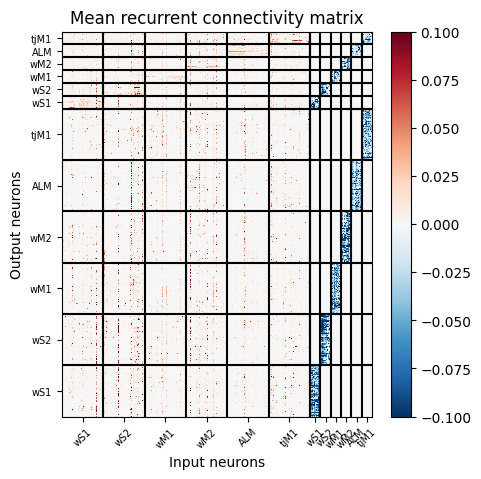

In [2]:
# Plot the mean recurrent connectivity matrix 
w_rec = model.rsnn._w_rec.detach().mean(0)
# Here all weights are positive, because the sign is calculated when we compute the currents.
#   That's why we multiply by -1 to have inhibitory weights in blue.
sign_mask = torch.ones(w_rec.shape)
sign_mask[:, -model.rsnn.inhibitory:] = -1 
w_rec = w_rec * sign_mask

w_rec = w_rec.numpy()
plt.figure(figsize=(5, 5))
plt.pcolormesh(w_rec, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Mean recurrent connectivity matrix")
plt.xlabel("Input neurons")
plt.ylabel("Output neurons")
# lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
for i in range(200, 1400, 200):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
for i in range(1200, 1500, 50):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
# put the name of areas as a x label on the plot {wS1, wS2, wM1, wM2, ALM, tjM1}
xticks = [100, 300, 500, 700, 900, 1100, 1225, 1275, 1325, 1375, 1425, 1475]
xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
plt.yticks(xticks, xlabels, fontsize=7)
plt.savefig("weights.png", dpi=300, bbox_inches="tight")

In [49]:
with torch.no_grad():
    stims = torch.randint(2, size=(10,)) # binary vector of conditions (absence or presence of whisker stimulation)
    spikes, voltages, jaw, state = model(stims) # generation of the input spikes and simulation of the RSNN

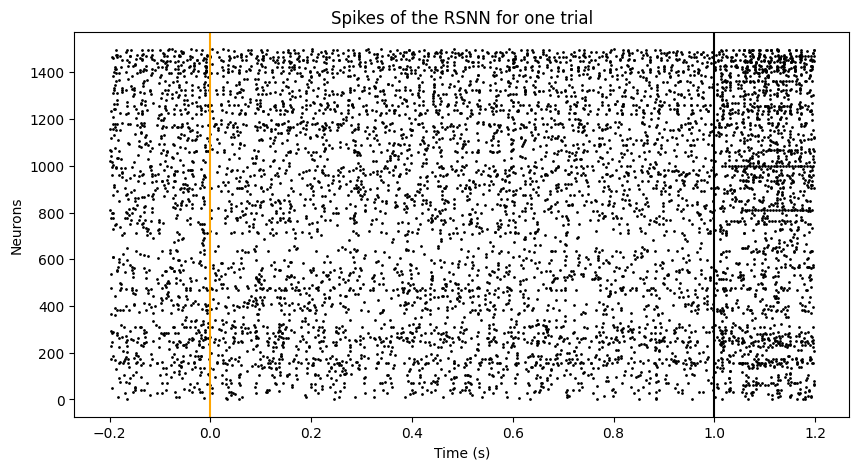

In [50]:
# here we plot the spikes of the neurons of the RSNN for one trial
plt.figure(figsize=(10, 5))
time = torch.arange(0, spikes.shape[1])*0.002 # time vector
sptms, sptns = torch.where(spikes[:,0] == 1) # indices of the spikes
plt.scatter(sptms*0.002-0.2, sptns, s=1, c="k")
plt.xlabel("Time (s)")
plt.ylabel("Neurons")
plt.title("Spikes of the RSNN for one trial")
plt.axvline(0, color="orange")
plt.axvline(1, color="k")
plt.savefig("spikes.png", dpi=300, bbox_inches="tight")

In [78]:
import utils.display as display
import numpy as np

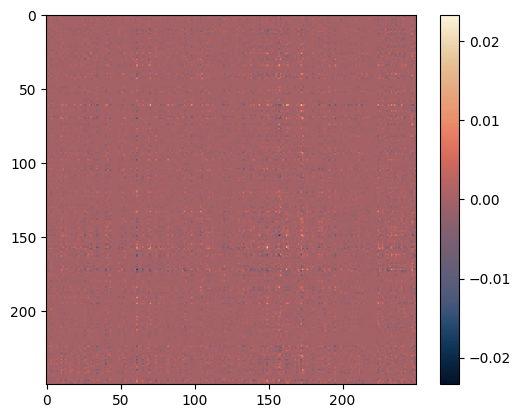

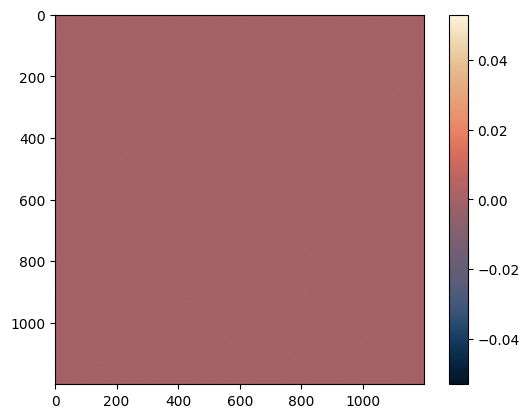

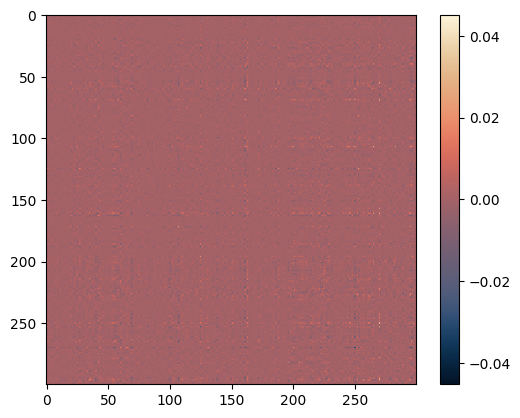

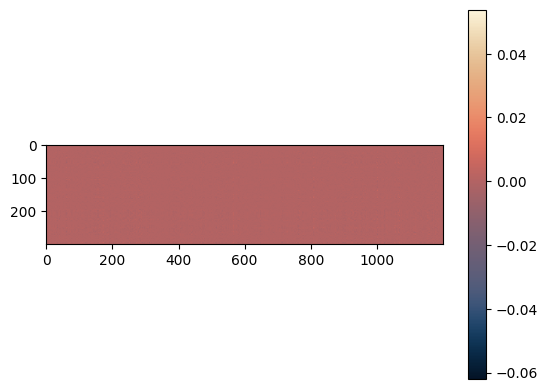

In [77]:
time = torch.arange(0, spikes.shape[1])*0.002 # time vector
spikes_fct = model.filter_fun1(spikes)
spikes_2fct = model.filter_fun2(spikes_fct)

L = lead_matrix(spikes_2fct[:, 0].detach().numpy().T)
display.matrix(L[:250, :250])
display.matrix(L[:model.rsnn.excitatory, :model.rsnn.excitatory])
display.matrix(L[model.rsnn.excitatory:, model.rsnn.excitatory:])
display.matrix(L[model.rsnn.excitatory:, :model.rsnn.excitatory])

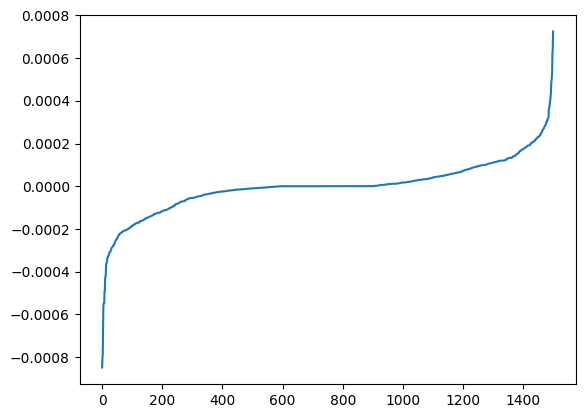

In [80]:
approx_order_neuron = np.mean(L, axis=1)
plt.plot(np.sort(approx_order_neuron))

In [127]:
idx_leading_neuron = np.where(approx_order_neuron > 0.0001)
idx_leading_neuron

(array([  11,   26,   34,   40,   52,   58,   61,   65,   77,   85,  119,
         120,  122,  123,  124,  133,  141,  145,  146,  149,  153,  155,
         158,  161,  169,  191,  195,  201,  204,  210,  213,  230,  241,
         246,  248,  250,  254,  255,  256,  262,  270,  271,  279,  284,
         292,  306,  312,  319,  326,  366,  369,  372,  380,  385,  386,
         387,  393,  394,  406,  409,  410,  423,  426,  440,  446,  447,
         464,  471,  472,  473,  476,  479,  490,  500,  514,  515,  516,
         521,  523,  531,  532,  542,  546,  551,  556,  565,  580,  581,
         595,  624,  625,  631,  635,  637,  647,  648,  655,  686,  711,
         712,  713,  714,  720,  721,  723,  727,  740,  745,  754,  762,
         776,  802,  806,  819,  825,  830,  832,  833,  836,  849,  851,
         879,  884,  898,  899,  901,  903,  905,  911,  912,  929,  933,
         935,  952,  953,  955,  956,  962,  963,  976,  981,  982,  987,
        1002, 1010, 1019, 1023, 1025, 

In [129]:
p_leading = idx_leading_neuron[0].shape[0]/approx_order_neuron.shape[0]
p_leading

0.15266666666666667

In [96]:
model.rsnn.area_index[idx_leading_neuron]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

(array([36., 40., 40., 34., 38., 41.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

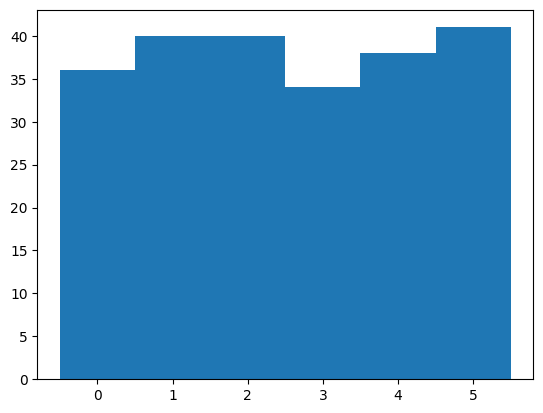

In [117]:
plt.hist(model.rsnn.area_index[idx_leading_neuron], bins=np.arange(7)-0.5)

(array([ 57., 172.]),
 array([-0.5,  0.5,  1.5]),
 <BarContainer object of 2 artists>)

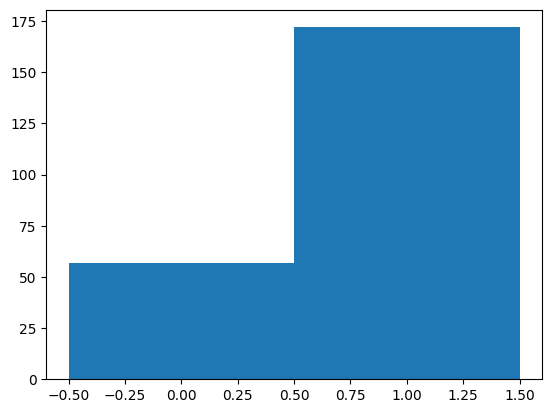

In [116]:
plt.hist(model.rsnn.excitatory_index[idx_leading_neuron]*1, np.arange(3)-0.5)

In [113]:
np.unique(model.rsnn.area_index[idx_leading_neuron], return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([36, 40, 40, 34, 38, 41]))

In [112]:
np.unique(model.rsnn.excitatory_index[idx_leading_neuron], return_counts=True)

(array([False,  True]), array([ 57, 172]))

In [130]:
counts = np.unique(model.rsnn.excitatory_index[idx_leading_neuron], return_counts=True)[1]
p_leading * (counts/np.sum(counts)) / np.array([1-model.rsnn.p_exc, model.rsnn.p_exc])

array([0.19      , 0.14333333])

In [135]:
p_leading

0.15266666666666667

In [132]:
counts/np.sum(counts)

array([0.2489083, 0.7510917])

In [133]:
np.array([1-model.rsnn.p_exc, model.rsnn.p_exc])

array([0.2, 0.8])

In [110]:
idx_leaded_neuron = np.where(approx_order_neuron < -0.0001)
idx_leaded_neuron

(array([   1,   10,   13,   21,   22,   27,   28,   38,   41,   53,   62,
          68,   74,   82,   92,  105,  129,  138,  140,  150,  160,  163,
         168,  170,  171,  172,  173,  186,  188,  211,  229,  231,  233,
         235,  240,  247,  252,  264,  272,  278,  280,  288,  315,  362,
         367,  368,  378,  379,  381,  404,  415,  439,  469,  470,  482,
         495,  533,  539,  548,  554,  564,  566,  567,  568,  575,  587,
         601,  604,  608,  617,  634,  636,  644,  653,  663,  665,  669,
         678,  681,  689,  697,  705,  709,  725,  728,  730,  737,  738,
         747,  752,  758,  759,  764,  768,  777,  780,  789,  798,  800,
         809,  812,  813,  820,  824,  831,  838,  852,  858,  862,  866,
         874,  875,  885,  892,  910,  916,  926,  927,  930,  939,  946,
         948,  951,  960,  961,  968,  969,  975,  985,  993, 1001, 1003,
        1012, 1015, 1016, 1017, 1020, 1021, 1024, 1028, 1032, 1042, 1054,
        1056, 1057, 1063, 1065, 1066, 

(array([39., 26., 26., 41., 45., 51.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

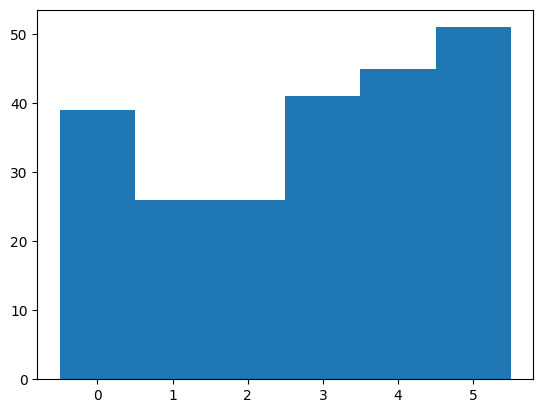

In [118]:
plt.hist(model.rsnn.area_index[idx_leaded_neuron], bins=np.arange(7)-0.5)

(array([ 57., 171.]),
 array([-0.5,  0.5,  1.5]),
 <BarContainer object of 2 artists>)

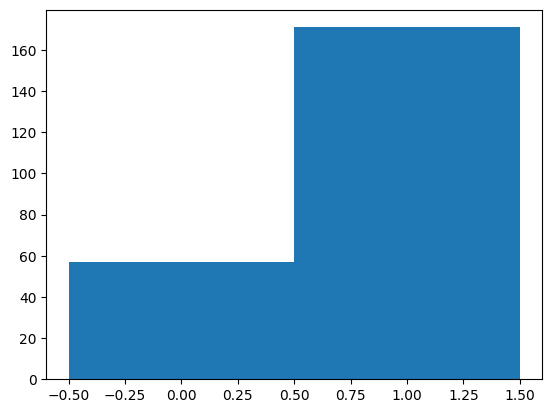

In [119]:
plt.hist(model.rsnn.excitatory_index[idx_leaded_neuron]*1, np.arange(3)-0.5)

In [136]:
w_rec

array([[ 0.00000000e+00,  2.55821564e-04,  9.99999996e-13, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 9.99999996e-13,  0.00000000e+00,  9.99999996e-13, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 9.99999996e-13,  3.87164910e-05,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 1.79939473e-03,  9.99999996e-13,  9.99999996e-13, ...,
        -0.00000000e+00, -1.08183004e-01, -1.81157701e-02],
       [ 2.67415773e-03,  9.99999996e-13,  3.12091470e-06, ...,
        -1.02670483e-01, -0.00000000e+00, -5.70412632e-03],
       [ 9.99999996e-13,  4.58973926e-04,  8.06727694e-05, ...,
        -1.61365904e-02, -1.71219427e-02, -0.00000000e+00]], dtype=float32)

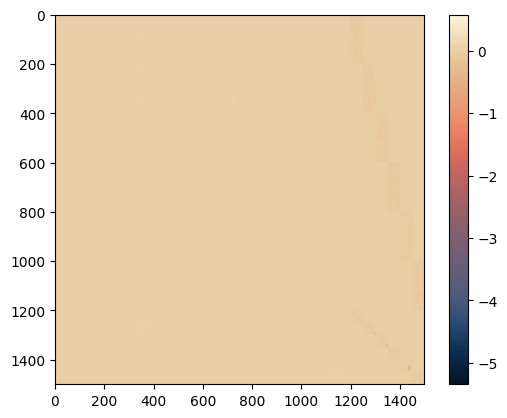

In [137]:
display.matrix(w_rec)

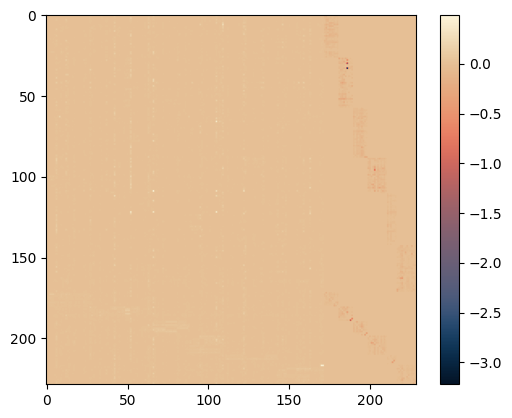

In [139]:
display.matrix(w_rec[idx_leading_neuron][:,idx_leading_neuron].squeeze())

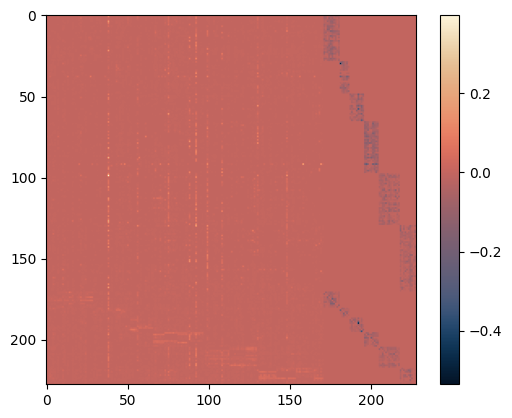

In [143]:
display.matrix(w_rec[idx_leaded_neuron][:,idx_leaded_neuron].squeeze())

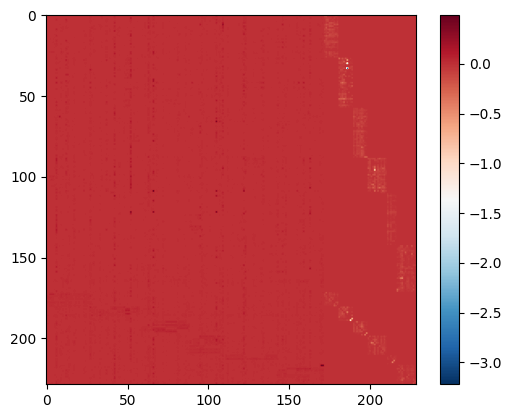

In [145]:
display.matrix(w_rec[idx_leading_neuron][:,idx_leading_neuron].squeeze(), 'RdBu_r')

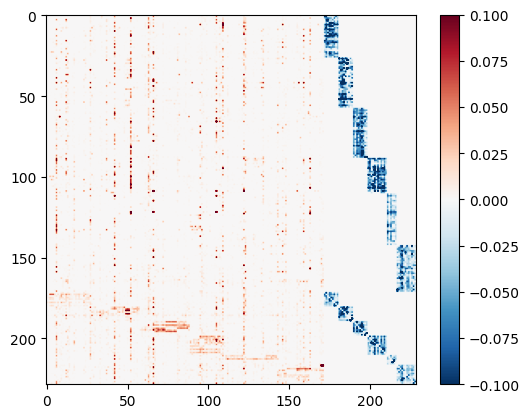

In [146]:
display.matrix(w_rec[idx_leading_neuron][:,idx_leading_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

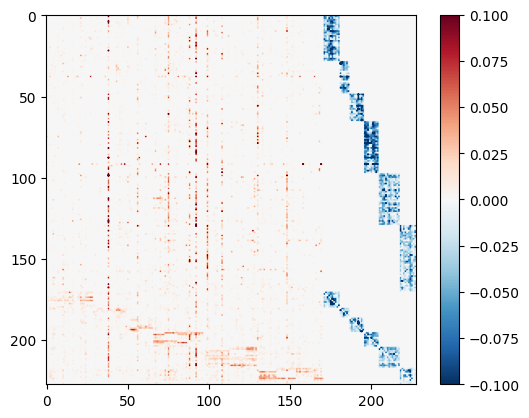

In [148]:
display.matrix(w_rec[idx_leaded_neuron][:,idx_leaded_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

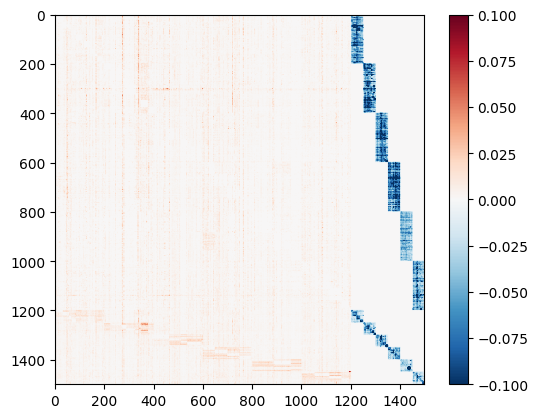

In [149]:
display.matrix(w_rec, 'RdBu_r', vmin=-0.1, vmax=0.1)


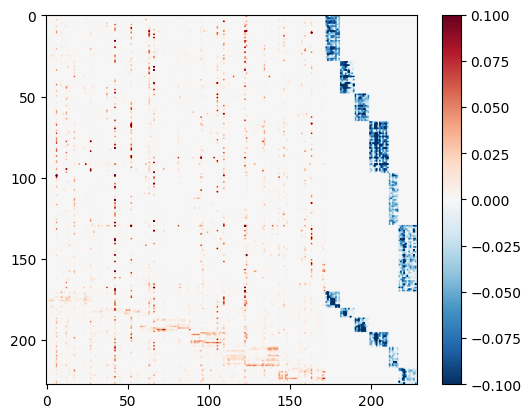

In [151]:
display.matrix(w_rec[idx_leaded_neuron][:,idx_leading_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

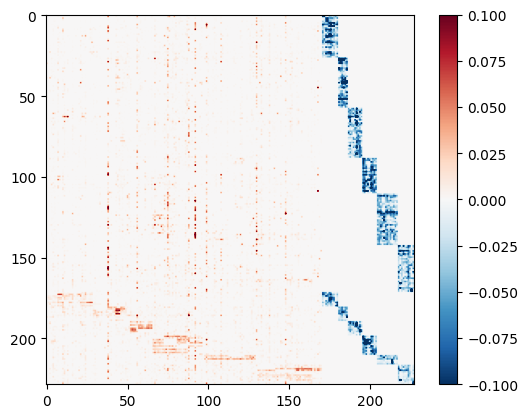

In [152]:
display.matrix(w_rec[idx_leading_neuron][:,idx_leaded_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

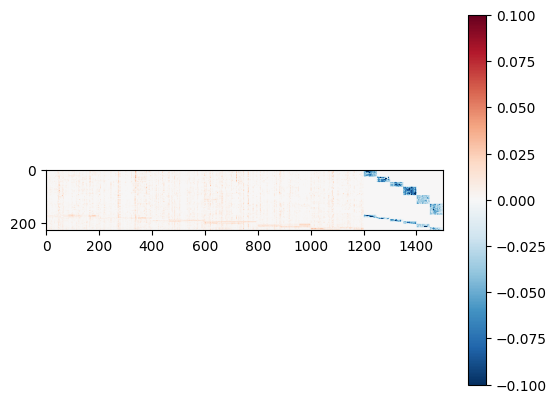

In [153]:
display.matrix(w_rec[idx_leaded_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

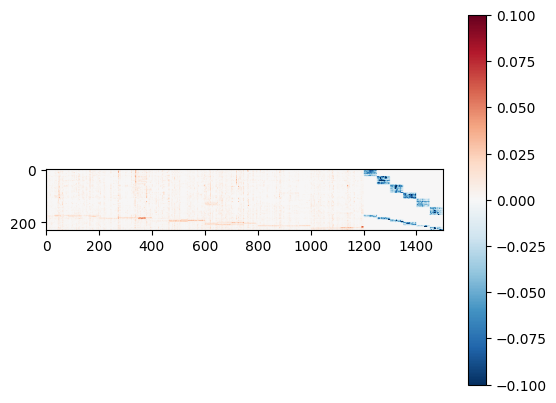

In [154]:
display.matrix(w_rec[idx_leading_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

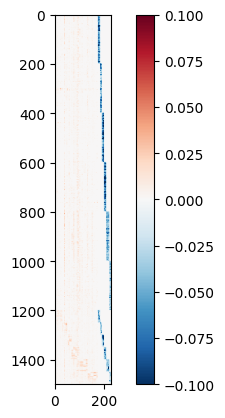

In [156]:
display.matrix(w_rec[:,idx_leaded_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

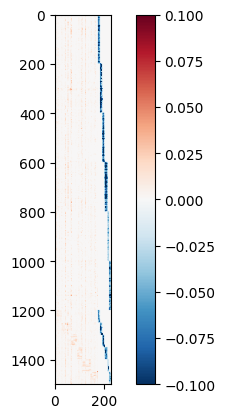

In [157]:
display.matrix(w_rec[:,idx_leading_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

In [158]:
idx_average_neuron = np.where(np.abs(approx_order_neuron) < 0.0001)

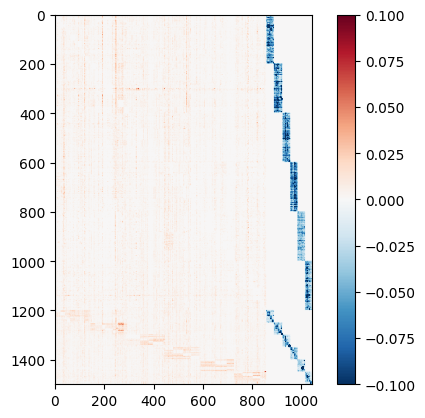

In [160]:
display.matrix(w_rec[:,idx_average_neuron].squeeze(), 'RdBu_r', vmin=-0.1, vmax=0.1)

(array([  1.,   0.,   2.,  20., 160., 736., 109.,  11.,   3.,   1.]),
 array([-0.04671243, -0.03808223, -0.02945204, -0.02082184, -0.01219164,
        -0.00356144,  0.00506876,  0.01369896,  0.02232916,  0.03095936,
         0.03958955]),
 <BarContainer object of 10 artists>)

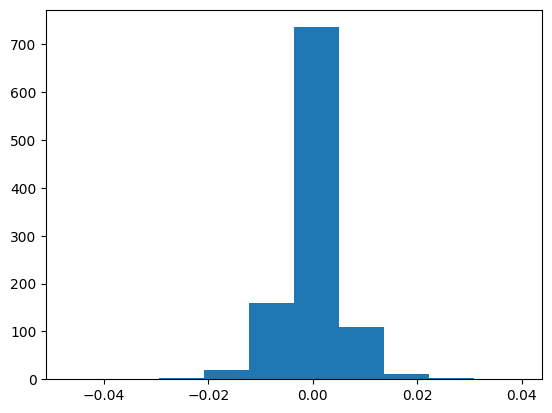

In [161]:
plt.hist(np.mean(w_rec[:,idx_average_neuron].squeeze(), axis=0))

(array([  1.,   2.,   3.,  24., 196., 834., 409.,  20.,   9.,   2.]),
 array([-0.05437697, -0.04498025, -0.03558353, -0.02618681, -0.01679009,
        -0.00739338,  0.00200335,  0.01140007,  0.02079678,  0.0301935 ,
         0.03959022]),
 <BarContainer object of 10 artists>)

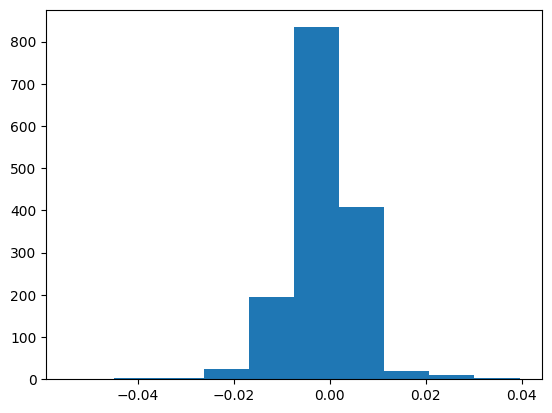

In [162]:
plt.hist(np.mean(w_rec[idx_average_neuron].squeeze(), axis=0))

(array([  1.,   2.,   7.,  19.,  27., 145.,  19.,   5.,   2.,   2.]),
 array([-0.03441936, -0.02827306, -0.02212677, -0.01598047, -0.00983417,
        -0.00368787,  0.00245843,  0.00860472,  0.01475102,  0.02089732,
         0.02704361]),
 <BarContainer object of 10 artists>)

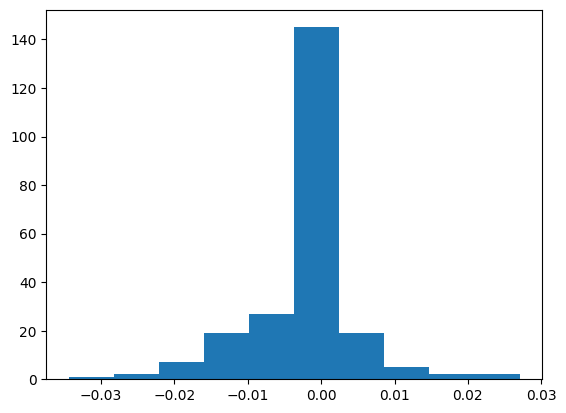

In [163]:
plt.hist(np.mean(w_rec[:,idx_leading_neuron].squeeze(), axis=0))

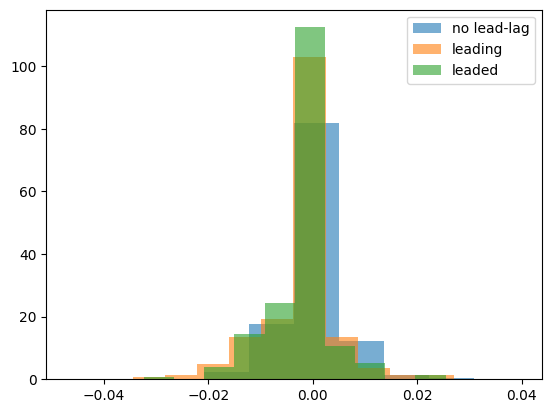

In [170]:
plt.hist(np.mean(w_rec[:,idx_average_neuron].squeeze(), axis=0), label='no lead-lag', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[:,idx_leading_neuron].squeeze(), axis=0), label='leading', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[:,idx_leaded_neuron].squeeze(), axis=0), label='leaded', alpha=0.6, density=True)
plt.legend()

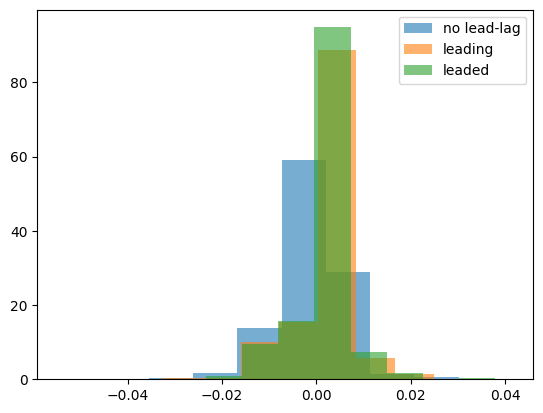

In [171]:
plt.hist(np.mean(w_rec[idx_average_neuron].squeeze(), axis=0), label='no lead-lag', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[idx_leading_neuron].squeeze(), axis=0), label='leading', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[idx_leaded_neuron].squeeze(), axis=0), label='leaded', alpha=0.6, density=True)
plt.legend()

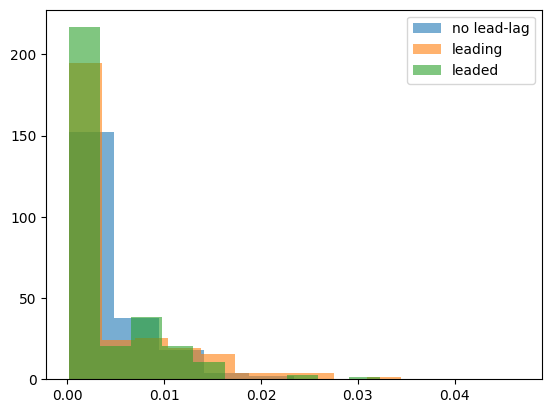

In [172]:
plt.hist(np.abs(np.mean(w_rec[:,idx_average_neuron].squeeze(), axis=0)), label='no lead-lag', alpha=0.6, density=True)
plt.hist(np.abs(np.mean(w_rec[:,idx_leading_neuron].squeeze(), axis=0)), label='leading', alpha=0.6, density=True)
plt.hist(np.abs(np.mean(w_rec[:,idx_leaded_neuron].squeeze(), axis=0)), label='leaded', alpha=0.6, density=True)
plt.legend()

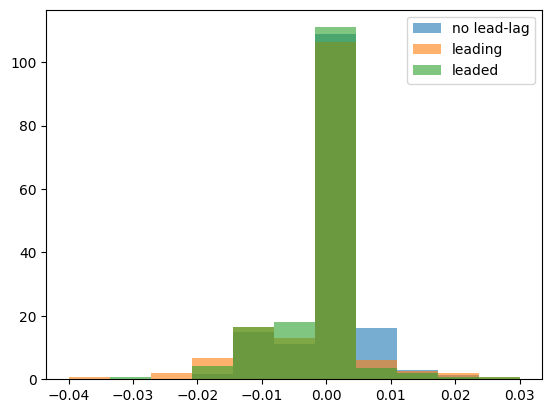

In [175]:
bins = np.linspace(-0.04, 0.03, 12)
plt.hist(np.mean(w_rec[:,idx_average_neuron].squeeze(), axis=0), bins=bins, label='no lead-lag', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[:,idx_leading_neuron].squeeze(), axis=0), bins=bins, label='leading', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[:,idx_leaded_neuron].squeeze(), axis=0), bins=bins, label='leaded', alpha=0.6, density=True)
plt.legend()

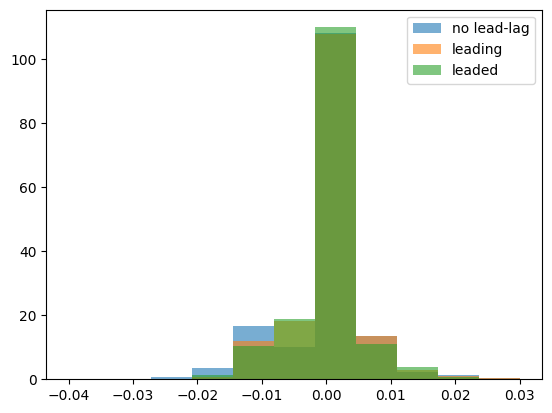

In [176]:
bins = np.linspace(-0.04, 0.03, 12)
plt.hist(np.mean(w_rec[idx_average_neuron].squeeze(), axis=0), bins=bins, label='no lead-lag', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[idx_leading_neuron].squeeze(), axis=0), bins=bins, label='leading', alpha=0.6, density=True)
plt.hist(np.mean(w_rec[idx_leaded_neuron].squeeze(), axis=0), bins=bins, label='leaded', alpha=0.6, density=True)
plt.legend()

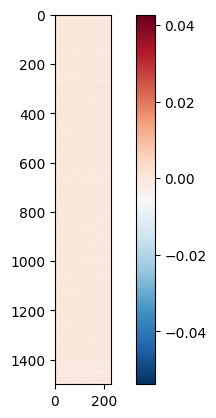

In [182]:
display.matrix(L[:,idx_leading_neuron].squeeze(), 'RdBu_r')

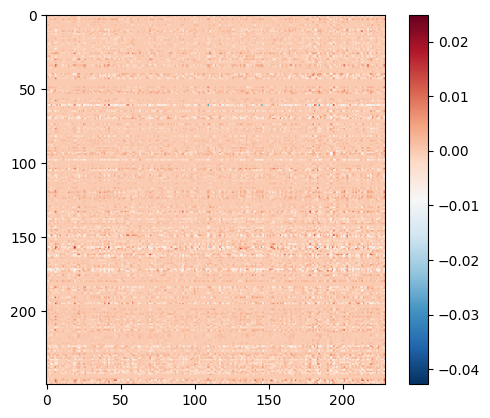

In [191]:
display.matrix(L[:250, idx_leading_neuron].squeeze(), 'RdBu_r')

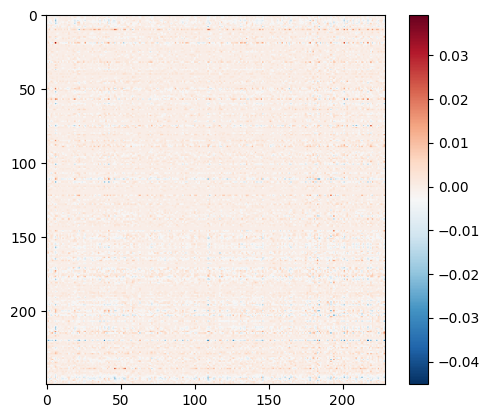

In [192]:
display.matrix(L[-250:, idx_leading_neuron].squeeze(), 'RdBu_r')

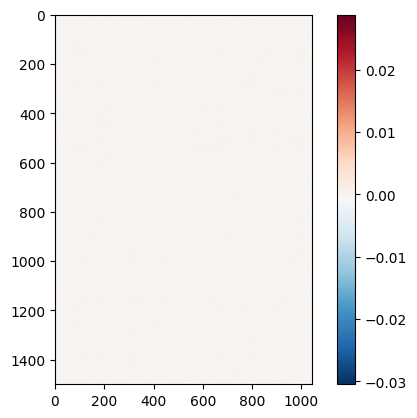

In [183]:
display.matrix(L[:,idx_average_neuron].squeeze(), 'RdBu_r')

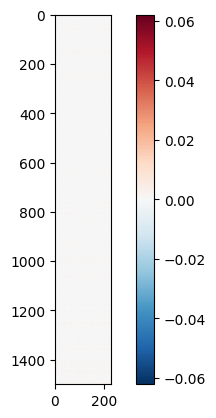

In [188]:
display.matrix(L[:,idx_leaded_neuron].squeeze(), 'RdBu_r')

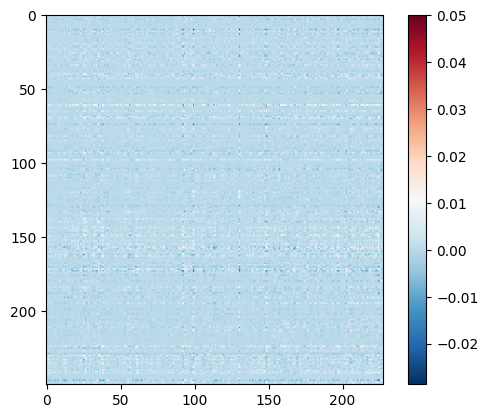

In [189]:
display.matrix(L[:250,idx_leaded_neuron].squeeze(), 'RdBu_r')

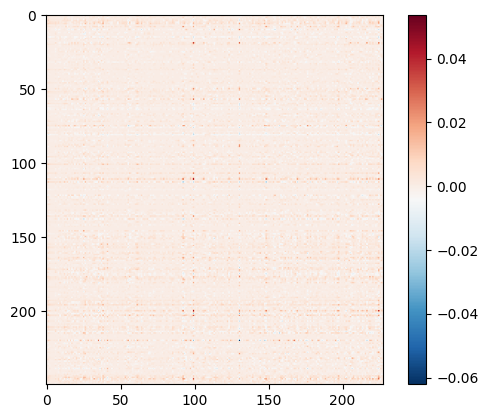

In [190]:
display.matrix(L[-250:,idx_leaded_neuron].squeeze(), 'RdBu_r')

In [196]:
idx_leader, idx_follower = np.unravel_index(np.argmax(np.abs(L)), L.shape)

In [200]:
L[idx_leader, idx_follower]

np.float64(0.06210937350988388)

In [198]:
print(model.rsnn.excitatory_index[idx_leader])
print(model.rsnn.excitatory_index[idx_follower])
print(model.rsnn.area_index[idx_leader])
print(model.rsnn.area_index[idx_follower])

tensor(True)
tensor(False)
tensor(5)
tensor(5)


In [199]:
w_rec[idx_follower, idx_leader] # leader -> follower

np.float32(0.00021230418)

In [201]:
w_rec[idx_leader, idx_follower] # follower -> leader (inversion leads to this positive leading effect, so the relation should be seen as reversed)

np.float32(-0.10270348)

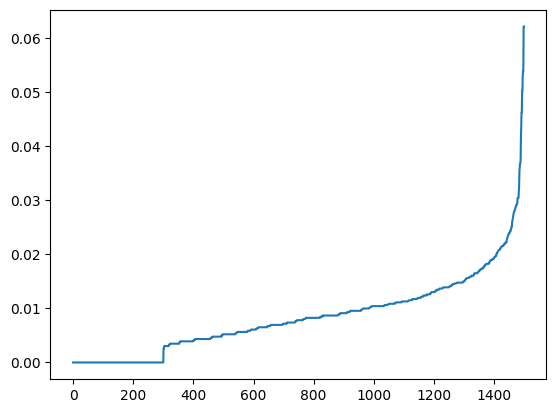

In [224]:
approx_leadlag_neuron = np.max(np.abs(L), axis=1)
plt.plot(np.sort(approx_leadlag_neuron))

In [226]:
idx_strong_leadlag_neuron = np.where(approx_leadlag_neuron > 0.01)

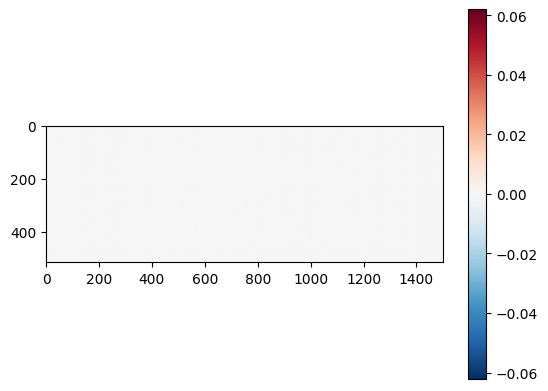

In [227]:
display.matrix(L[idx_strong_leadlag_neuron].squeeze(), 'RdBu_r')

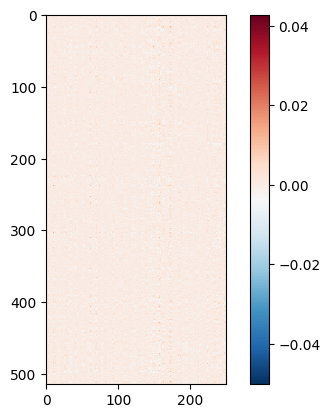

In [228]:
display.matrix(L[idx_strong_leadlag_neuron, :250].squeeze(), 'RdBu_r')

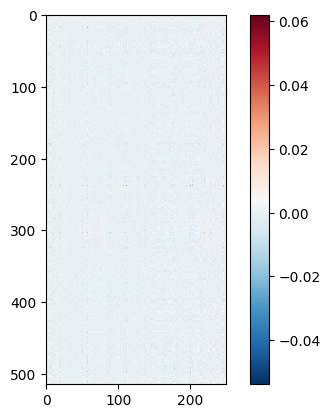

In [229]:
display.matrix(L[idx_strong_leadlag_neuron, -250:].squeeze(), 'RdBu_r')

In [232]:
sent_connectivity = []
received_connectivity = []
for idx in idx_strong_leadlag_neuron[0]:
    other_idx = np.argmax(np.abs(L[idx]))
    sent_connectivity += [w_rec[other_idx, idx]]
    received_connectivity += [w_rec[idx, other_idx]]
    
sent_connectivity = np.array(sent_connectivity)
received_connectivity = np.array(received_connectivity)

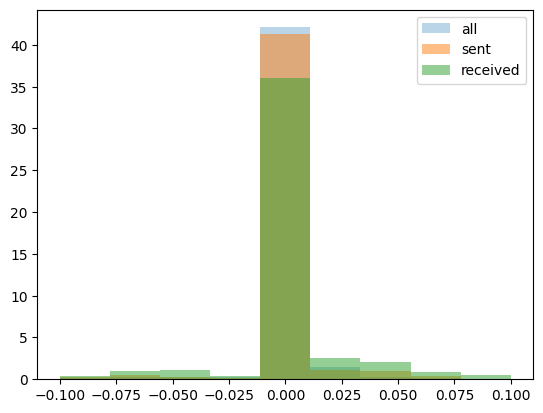

In [244]:
bins = np.linspace(-0.1, 0.1, 10)
plt.hist(w_rec.flatten(), bins=bins, alpha=0.3, label='all', density=True)
plt.hist(sent_connectivity, bins=bins, alpha=0.5, label='sent', density=True)
plt.hist(received_connectivity, bins=bins, alpha=0.5, label='received', density=True)
plt.legend()

In [247]:
for s, r, idx in zip(sent_connectivity, received_connectivity, idx_strong_leadlag_neuron[0]):
    if np.abs(s) > 0.1 or np.abs(r) > 0.1:
        print(s, r, np.max(np.abs(L[idx])))

0.009275788 0.1359402 0.01171875
1e-12 0.11242512 0.0325520858168602
0.2888993 1e-12 0.02907986007630825
1e-12 -0.11022142 0.01215277798473835
0.22075224 1e-12 0.01171875
0.12187478 1e-12 0.0529513880610466
0.11850144 -0.0 0.053819440305233
0.33189029 0.00016808425 0.02734374813735485
0.00021230418 -0.10270348 0.06210937350988388
-0.0 0.11850144 0.053819440305233
-0.14178936 8.875009e-07 0.0212673619389534
-0.10143952 0.013847047 0.0182291641831398
-0.10270348 0.00021230418 0.06210937350988388


In [249]:
for s, r, idx in zip(sent_connectivity, received_connectivity, idx_strong_leadlag_neuron[0]):
    if np.max(np.abs(L[idx])) > 0.04:
        print(s, r, np.max(np.abs(L[idx])))

0.00025585113 0.04696691 0.0501302108168602
0.12187478 1e-12 0.0529513880610466
0.04696691 0.00025585113 0.0501302108168602
0.11850144 -0.0 0.053819440305233
0.00021230418 -0.10270348 0.06210937350988388
0.012953486 0.011216701 0.0434027798473835
1e-12 0.020931538 0.0462239608168602
-0.0 0.00057519914 0.0416666641831398
-0.0 0.11850144 0.053819440305233
-0.0 0.0049373503 0.0462239570915699
-0.10270348 0.00021230418 0.06210937350988388
